In [259]:
import pymc as pm
import pandas as pd
import numpy as np
from pytensor import tensor as pt
import arviz as az
from matplotlib import pyplot as plt
import seaborn as sns
from pymc import do, observe

In [260]:
df = pd.read_csv('sem_data.csv')
df.head()

,motiv,harm,stabi,ppsych,ses,verbal,read,arith,spell
0,-7.907122,-5.075312,-3.138836,-17.800210,4.766450,-3.633360,-3.488981,-9.989121,-6.567873
1,1.751478,-4.155847,3.520752,7.009367,-6.048681,-7.693461,-4.520552,8.196238,8.778973
2,14.472570,-4.540677,4.070600,23.734260,-16.970670,-3.909941,-4.818170,7.529984,-5.688716
3,-1.165421,-5.668406,2.600437,1.493158,1.396363,21.409450,-3.138441,5.730547,-2.915676
4,-4.222899,-10.072150,-6.030737,-5.985864,-18.376400,-1.438816,-2.009742,-0.623953,-1.024624


## Measurment Model

In [282]:
coords = {
    "obs": list(range(len(df))),
    "indicators": ["motiv", "harm", "stabi", "verbal", "ses", "ppsych", "read", "arith", "spell"],
    "indicators_1": ["motiv", "harm", "stabi"],
    "indicators_2": ["verbal", "ses", "ppsych"],
    "indicators_3": ["read", "arith", "spell"],
    "latent": ["adjust", "risk", "achieve"],
}

def make_lambda(indicators, name='lambdas1', priors=[1, 10]):
    """ Takes an argument indicators which is a string in the coords dict"""
    temp_name = name + '_'
    lambdas_ = pm.Normal(temp_name, priors[0], priors[1], dims=(indicators))
    # Force a fixed scale on the factor loadings for factor 1
    lambdas_1 = pm.Deterministic(
        name, pt.set_subtensor(lambdas_[0], 1), dims=(indicators)
    )
    return lambdas_1

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

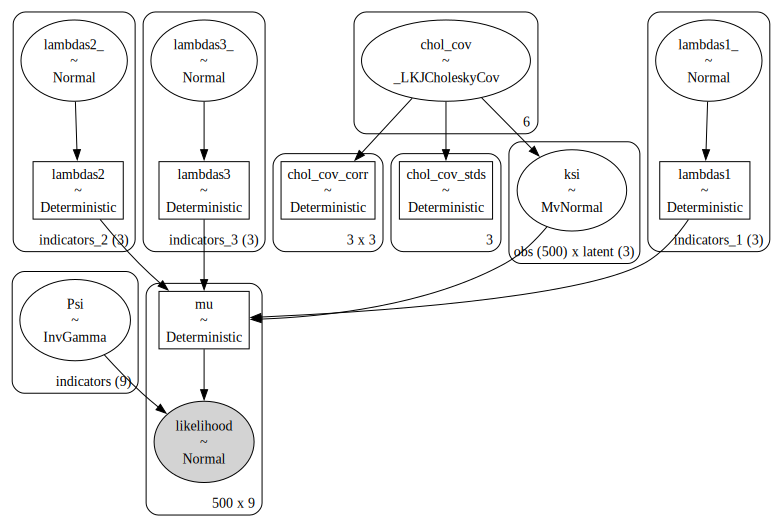

In [283]:
obs_idx = list(range(len(df)))
with pm.Model(coords=coords) as model:

    # Set up Factor Loadings
    lambdas_1 = make_lambda('indicators_1', 'lambdas1')
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, 2])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3')
    # Specify covariance structure between latent factors
    kappa = 0
    sd_dist = pm.Exponential.dist(1.0, shape=3)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=3, eta=2, sd_dist=sd_dist, compute_corr=True)
    ksi = pm.MvNormal("ksi", kappa, chol=chol, dims=("obs", "latent"))

    # Construct Pseudo Observation matrix based on Factor Loadings
    m1 = ksi[obs_idx, 0] * lambdas_1[0]
    m2 = ksi[obs_idx, 0] * lambdas_1[1]
    m3 = ksi[obs_idx, 0] * lambdas_1[2]
    m4 = ksi[obs_idx, 1] * lambdas_2[0]
    m5 = ksi[obs_idx, 1] * lambdas_2[1]
    m6 = ksi[obs_idx, 1] * lambdas_2[2]
    m7 = ksi[obs_idx, 2] * lambdas_3[0]
    m8 = ksi[obs_idx, 2] * lambdas_3[1]
    m9 = ksi[obs_idx, 2] * lambdas_3[2]

    mu = pm.Deterministic("mu", pm.math.stack([m1, m2, m3, m4, m5, m6, m7, m8, m9]).T)

    ## Error Terms
    Psi = pm.InverseGamma("Psi", 2, 13, dims="indicators")

    # Likelihood
    _ = pm.Normal(
        "likelihood",
        mu,
        Psi,
        observed=df[coords['indicators']].values,
    )

    idata = pm.sample(
        draws=1000,
        chains=4,
        nuts_sampler="numpyro", target_accept=0.95, idata_kwargs={"log_likelihood": True}, 
        tune=2000,
        random_seed=150
    )
    idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(model)


In [284]:
az.summary(idata, var_names=["lambdas1", "lambdas2", "lambdas3"])

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambdas1[motiv],1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
lambdas1[harm],0.895,0.043,0.814,0.973,0.002,0.001,521.0,1401.0,1.01
lambdas1[stabi],0.703,0.047,0.617,0.791,0.002,0.001,801.0,1571.0,1.01
lambdas2[verbal],1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
lambdas2[ses],0.842,0.087,0.679,1.000,0.004,0.003,453.0,1294.0,1.01
lambdas2[ppsych],-0.801,0.084,-0.969,-0.653,0.004,0.003,521.0,1276.0,1.00
lambdas3[read],1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
lambdas3[arith],0.841,0.035,0.773,0.906,0.001,0.001,1955.0,2586.0,1.00
lambdas3[spell],0.981,0.029,0.927,1.037,0.001,0.001,1123.0,1700.0,1.00


/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


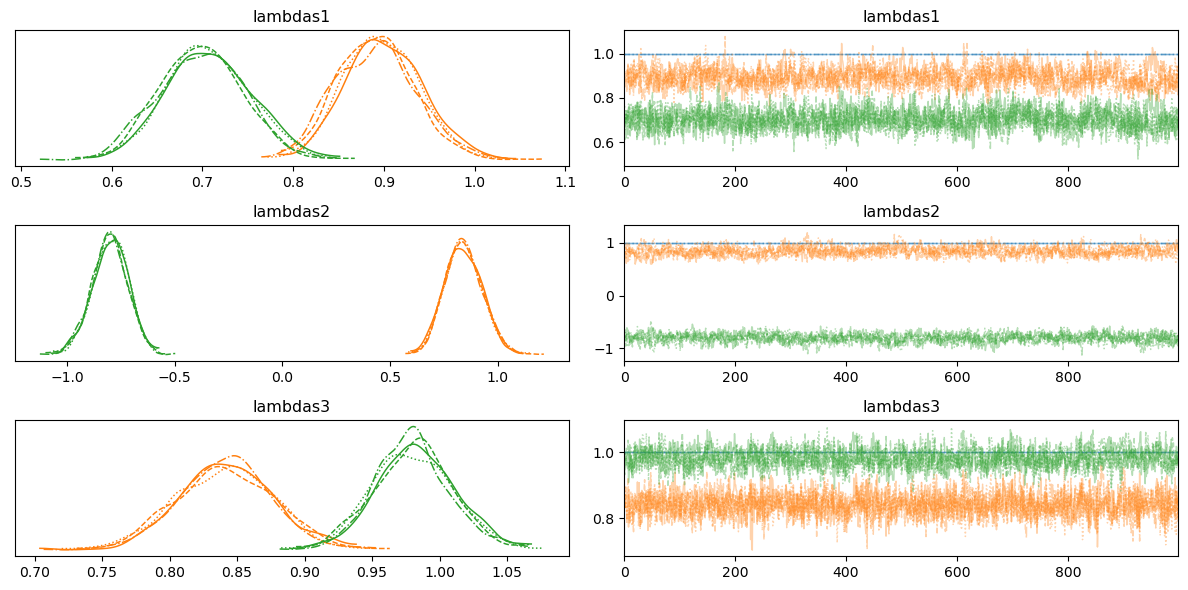

In [285]:
az.plot_trace(idata, var_names=['lambdas1', 'lambdas2', 'lambdas3'])
plt.tight_layout();

In [266]:
def make_factor_loadings_df(idata):
    factor_loadings = pd.DataFrame(
        az.summary(
            idata, var_names=["lambdas1", "lambdas2", "lambdas3"]
        )["mean"]
    ).reset_index()
    factor_loadings["factor"] = factor_loadings["index"].str.split("[", expand=True)[0]
    factor_loadings.columns = ["factor_loading", "factor_loading_weight", "factor"]
    factor_loadings["factor_loading_weight_sq"] = factor_loadings["factor_loading_weight"] ** 2
    factor_loadings["sum_sq_loadings"] = factor_loadings.groupby("factor")[
        "factor_loading_weight_sq"
    ].transform(sum)
    factor_loadings["error_variances"] = az.summary(idata, var_names=["Psi"])["mean"].values
    factor_loadings["total_indicator_variance"] = (
        factor_loadings["factor_loading_weight_sq"] + factor_loadings["error_variances"]
    )
    factor_loadings["total_variance"] = factor_loadings["total_indicator_variance"].sum()
    factor_loadings["indicator_explained_variance"] = (
        factor_loadings["factor_loading_weight_sq"] / factor_loadings["total_variance"]
    )
    factor_loadings["factor_explained_variance"] = (
        factor_loadings["sum_sq_loadings"] / factor_loadings["total_variance"]
    )
    num_cols = [c for c in factor_loadings.columns if not c in ["factor_loading", "factor"]]
    return factor_loadings


pd.set_option("display.max_colwidth", 15)
factor_loadings = make_factor_loadings_df(idata)
num_cols = [c for c in factor_loadings.columns if not c in ["factor_loading", "factor"]]
factor_loadings.style.format("{:.3f}", subset=num_cols).background_gradient(
    axis=0, subset=["indicator_explained_variance", "factor_explained_variance"]
)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_51797/2929805399.py:12: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pan

,factor_loading,factor_loading_weight,factor,factor_loading_weight_sq,sum_sq_loadings,error_variances,total_indicator_variance,total_variance,indicator_explained_variance,factor_explained_variance
0,lambdas1[motiv],1.000,lambdas1,1.000,2.295,3.676,4.676,60.931,0.016,0.038
1,lambdas1[harm],0.895,lambdas1,0.801,2.295,5.623,6.424,60.931,0.013,0.038
2,lambdas1[stabi],0.703,lambdas1,0.494,2.295,7.605,8.099,60.931,0.008,0.038
3,lambdas2[verbal],1.000,lambdas2,1.000,2.351,6.915,7.915,60.931,0.016,0.039
4,lambdas2[ses],0.842,lambdas2,0.709,2.351,8.027,8.736,60.931,0.012,0.039
5,lambdas2[ppsych],-0.801,lambdas2,0.642,2.351,8.242,8.884,60.931,0.011,0.039
6,lambdas3[read],1.000,lambdas3,1.000,2.670,3.409,4.409,60.931,0.016,0.044
7,lambdas3[arith],0.841,lambdas3,0.707,2.670,6.168,6.875,60.931,0.012,0.044
8,lambdas3[spell],0.981,lambdas3,0.962,2.670,3.951,4.913,60.931,0.016,0.044


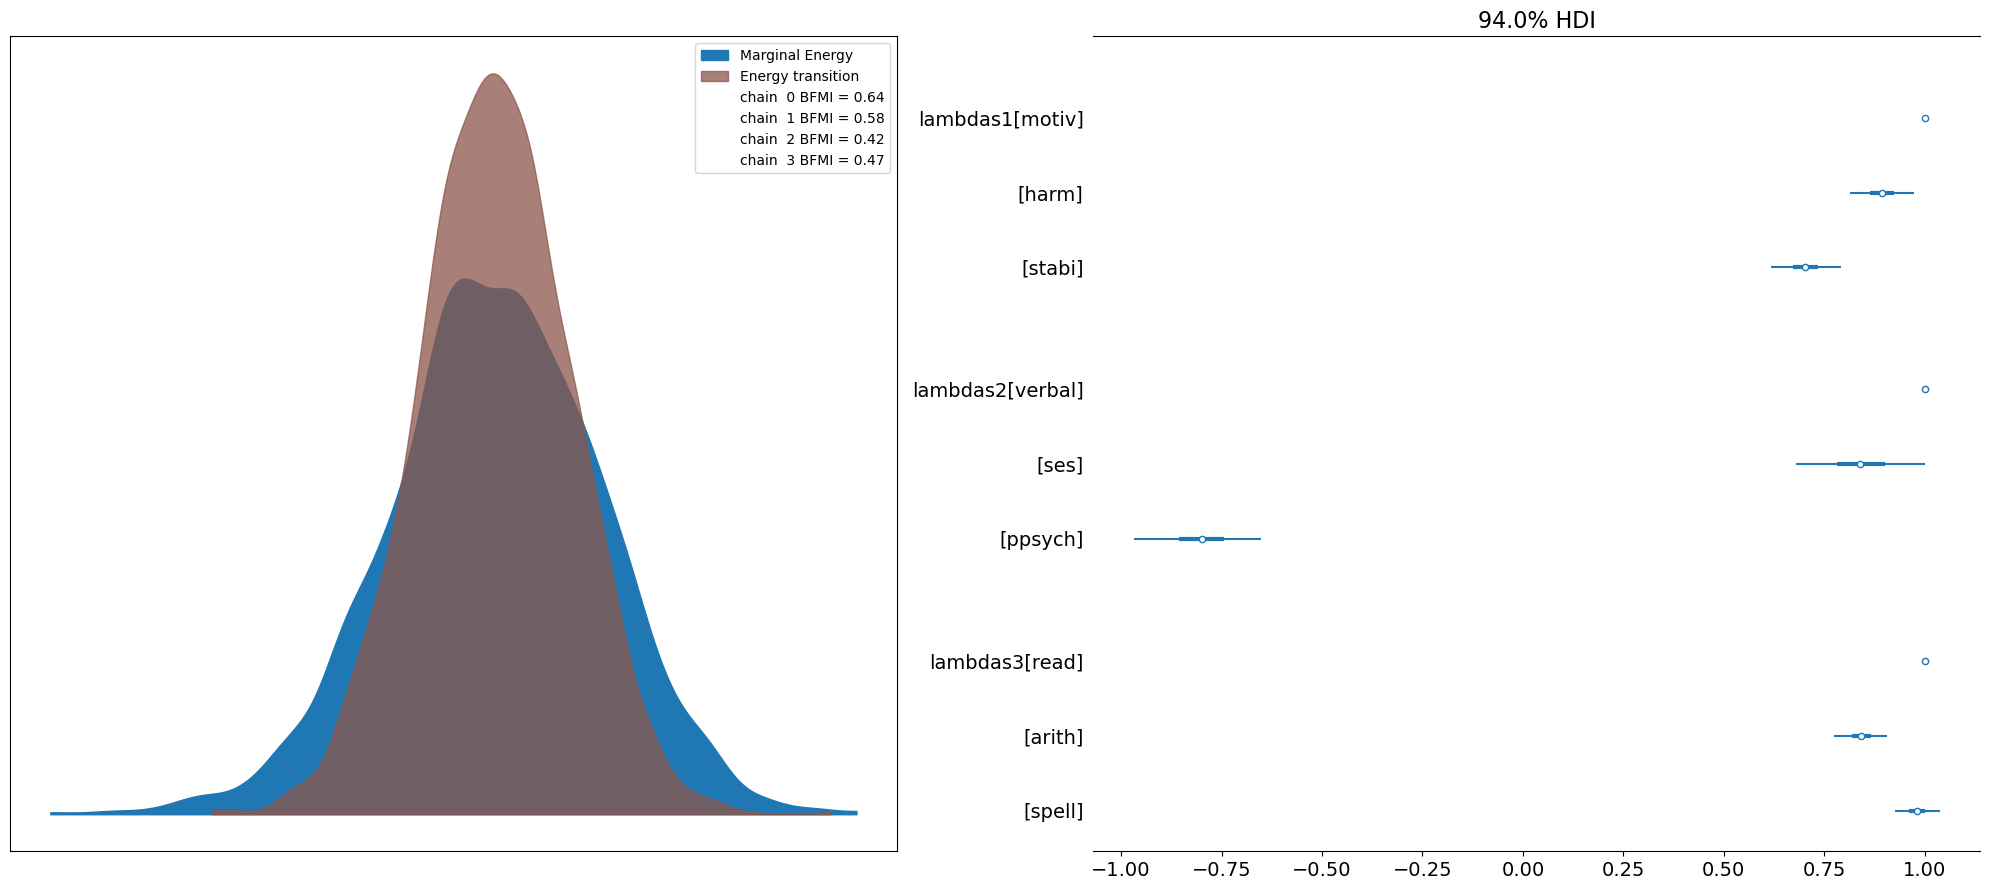

In [267]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9))
axs = axs.flatten()
az.plot_energy(idata, ax=axs[0])
az.plot_forest(idata, var_names=["lambdas1", "lambdas2", "lambdas3"], combined=True, ax=axs[1]);
plt.tight_layout();

In [286]:
drivers = coords['indicators']
def get_posterior_resids(idata, samples=100, metric="cov"):
    resids = []
    for i in range(100):
        if metric == "cov":
            model_cov = pd.DataFrame(
                az.extract(idata["posterior_predictive"])["likelihood"][:, :, i]
            ).cov()
            obs_cov = df[drivers].cov()
        else:
            model_cov = pd.DataFrame(
                az.extract(idata["posterior_predictive"])["likelihood"][:, :, i]
            ).corr()
            obs_cov = df[drivers].corr()
        model_cov.index = obs_cov.index
        model_cov.columns = obs_cov.columns
        residuals = model_cov - obs_cov
        resids.append(residuals.values.flatten())

    residuals_posterior = pd.DataFrame(pd.DataFrame(resids).mean().values.reshape(9, 9))
    residuals_posterior.index = obs_cov.index
    residuals_posterior.columns = obs_cov.index
    return residuals_posterior


residuals_posterior_cov = get_posterior_resids(idata, 1000)
residuals_posterior_corr = get_posterior_resids(idata, 1000, metric="corr")

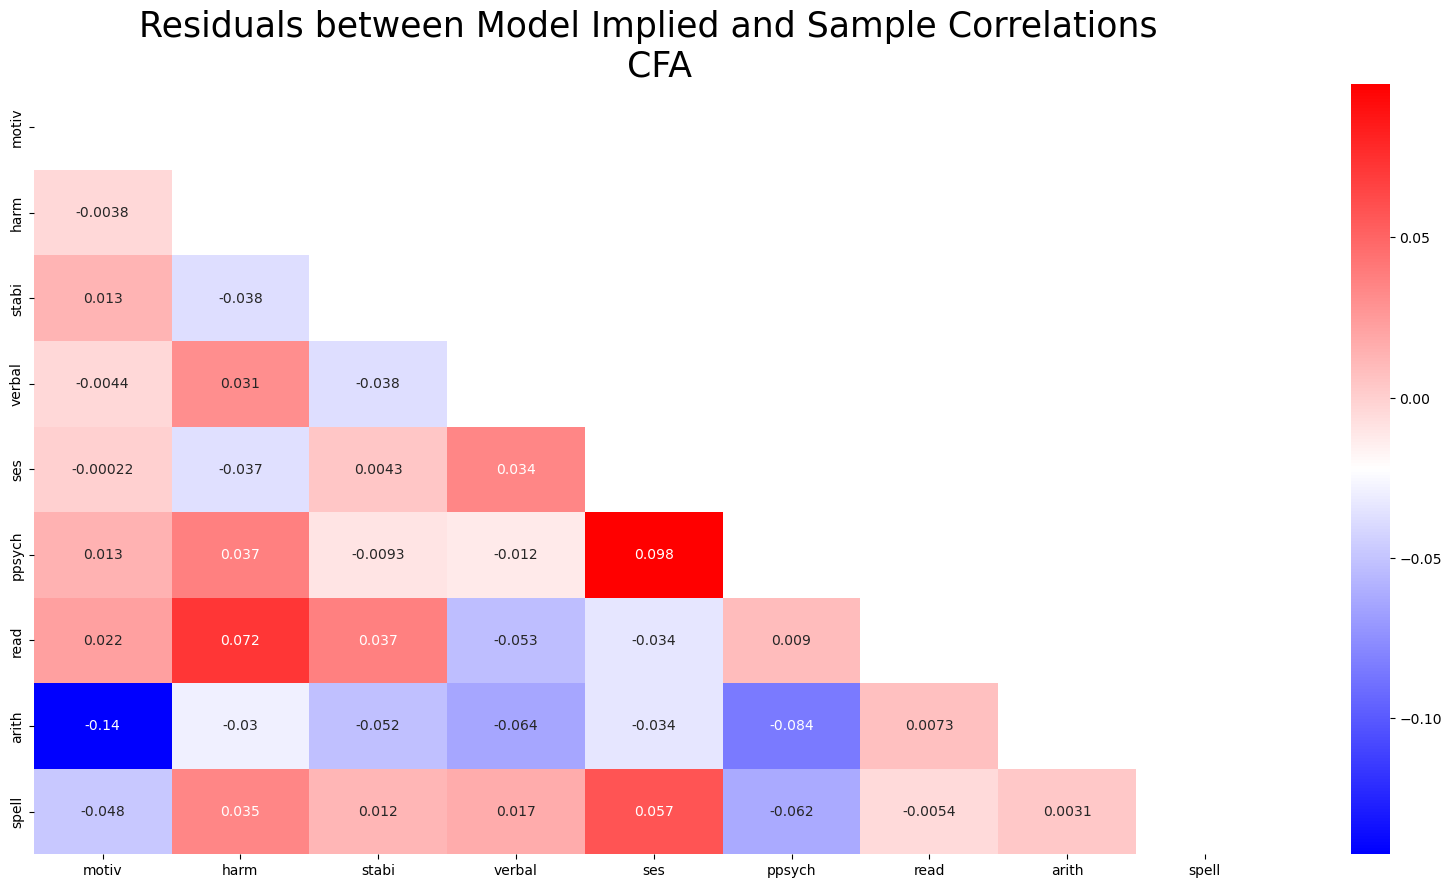

In [287]:
fig, ax = plt.subplots(figsize=(20, 10))
mask = np.triu(np.ones_like(residuals_posterior_corr, dtype=bool))
ax = sns.heatmap(residuals_posterior_corr, annot=True, cmap="bwr", mask=mask)
ax.set_title("Residuals between Model Implied and Sample Correlations \n CFA", fontsize=25);

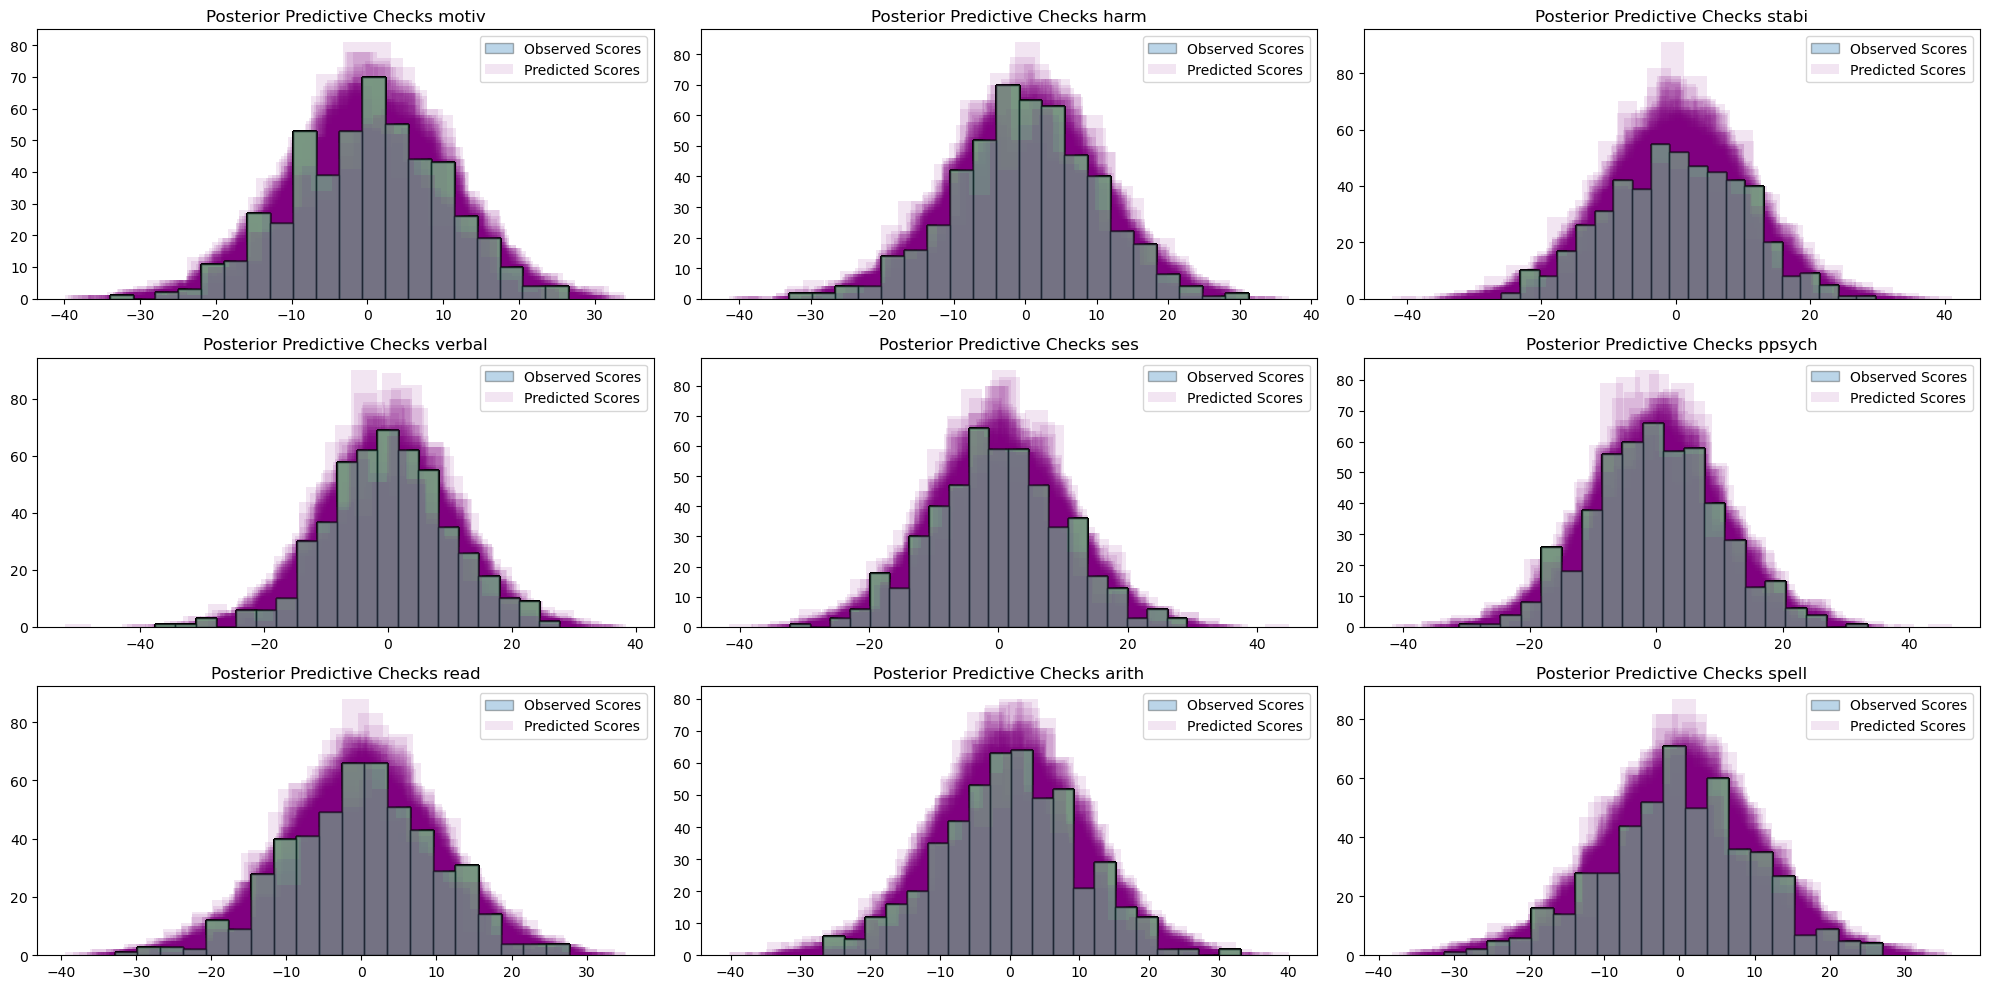

In [288]:
def make_ppc(
    idata,
    samples=100,
    drivers=drivers,
    dims=(3, 3),
):
    fig, axs = plt.subplots(dims[0], dims[1], figsize=(20, 10))
    axs = axs.flatten()
    for i in range(len(drivers)):
        for j in range(samples):
            temp = az.extract(idata["posterior_predictive"].sel({"likelihood_dim_3": i}))[
                "likelihood"
            ].values[:, j]
            temp = pd.DataFrame(temp, columns=["likelihood"])
            if j == 0:
                axs[i].hist(df[drivers[i]], alpha=0.3, ec="black", bins=20, label="Observed Scores")
                axs[i].hist(
                    temp["likelihood"], color="purple", alpha=0.1, bins=20, label="Predicted Scores"
                )
            else:
                axs[i].hist(df[drivers[i]], alpha=0.3, ec="black", bins=20)
                axs[i].hist(temp["likelihood"], color="purple", alpha=0.1, bins=20)
            axs[i].set_title(f"Posterior Predictive Checks {drivers[i]}")
            axs[i].legend()
    plt.tight_layout()
    plt.show()


make_ppc(idata)

## SEM Model

In [289]:
import numpy as np
import pandas as pd
data = np.random.multivariate_normal([0,0,0], [[1, 0, 0], [0,1, 0], [0, 0, 1]], size=(500))
data = np.ones((500, 3))
betas = np.zeros((3, 3))
betas[1, 0] = 0.5
betas[1, 2] = 0.5
betas[0, 2] = 0.7

B_matrix = pd.DataFrame(betas, index=['adjust_coef', 'risk_coef', 'achieve_coef'], 
                                columns=['adjust_target', 'risk_target', 'achieve_target'])
data = pd.DataFrame(data, columns=['adjust', 'risk', 'achieve'])
B_matrix

,adjust_target,risk_target,achieve_target
adjust_coef,0.0,0.0,0.7
risk_coef,0.5,0.0,0.5
achieve_coef,0.0,0.0,0.0


In [290]:
data.head()

,adjust,risk,achieve
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [291]:
np.dot(data, B_matrix)

array([[0.5, 0. , 1.2],
       [0.5, 0. , 1.2],
       [0.5, 0. , 1.2],
       ...,
       [0.5, 0. , 1.2],
       [0.5, 0. , 1.2],
       [0.5, 0. , 1.2]])

In [292]:


def make_sem():
    coords = {
    "obs": list(range(len(df))),
    "indicators": ["motiv", "harm", "stabi", "verbal", "ses", "ppsych", "read", "arith", "spell"],
    "indicators_1": ["motiv", "harm", "stabi"],
    "indicators_2": ["verbal", "ses", "ppsych"],
    "indicators_3": ["read", "arith", "spell"],
    "latent": ["adjust", "risk", "achieve"],
    "paths": ["risk->adjust", "risk-->achieve", "adjust-->achieve"]
    }

    obs_idx = list(range(len(df)))
    with pm.Model(coords=coords) as model:

        # Set up Factor Loadings
        lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5]) #adjust
        lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5]) # risk
        lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5]) # achieve
        
        # Specify covariance structure between latent factors
        sd_dist = pm.Exponential.dist(1.0, shape=3)
        chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=3, eta=2, sd_dist=sd_dist, compute_corr=True)
        ksi = pm.MvNormal("ksi", 0, chol=chol, dims=("obs", "latent"))

        ## Build Regression Components
        coefs = pm.Normal('betas', 0, .5, dims='paths')
        zeros = pt.zeros((3, 3))
        ## adjust ~ risk
        zeros1 = pt.set_subtensor(zeros[1, 0], coefs[0])
        ## achieve ~ risk + adjust
        zeros2 = pt.set_subtensor(zeros1[1, 2], coefs[1])
        coefs_ = pt.set_subtensor(zeros2[0, 2], coefs[2])
        
        structural_relations = pm.Deterministic('endogenous_structural_paths', pm.math.dot(ksi, coefs_))

        # Construct Pseudo Observation matrix based on Factor Loadings
        m1 = ksi[obs_idx, 0] * lambdas_1[0] +  structural_relations[obs_idx, 0] #adjust
        m2 = ksi[obs_idx, 0] * lambdas_1[1] +  structural_relations[obs_idx, 0] #adjust
        m3 = ksi[obs_idx, 0] * lambdas_1[2] +  structural_relations[obs_idx, 0] #adjust
        m4 = ksi[obs_idx, 1] * lambdas_2[0] +  structural_relations[obs_idx, 1]  #risk
        m5 = ksi[obs_idx, 1] * lambdas_2[1] +  structural_relations[obs_idx, 1]  #risk
        m6 = ksi[obs_idx, 1] * lambdas_2[2] +  structural_relations[obs_idx, 1]  #risk
        m7 = ksi[obs_idx, 2] * lambdas_3[0] +  structural_relations[obs_idx, 2]  #achieve
        m8 = ksi[obs_idx, 2] * lambdas_3[1] +  structural_relations[obs_idx, 2]  #achieve
        m9 = ksi[obs_idx, 2] * lambdas_3[2] +  structural_relations[obs_idx, 2]  #achieve

        mu = pm.Deterministic("mu", pm.math.stack([m1, m2, m3, m4, m5, m6, m7, m8, m9]).T)


        ## Error Terms
        Psi = pm.InverseGamma("Psi", 2, 13, dims="indicators")

        # Likelihood
        _ = pm.Normal(
            "likelihood",
            mu,
            Psi,
            observed=df[coords['indicators']].values,
        )

        idata = pm.sample(
            draws=2500,
            chains=4,
            #nuts_sampler="numpyro", 
            target_accept=0.90, idata_kwargs={"log_likelihood": True}, 
            random_seed=150,
            tune=1000,
        )
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, model

idata_sem, model_sem = make_sem()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, chol_cov, ksi, betas, Psi]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 164 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

In [293]:
az.summary(idata_sem, var_names=["lambdas1", "lambdas2", "lambdas3", "betas"])

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambdas1[motiv],1.000,0.000,1.000,1.000,0.000,0.000,10000.0,10000.0,NaN
lambdas1[harm],0.850,0.045,0.766,0.933,0.001,0.001,997.0,2361.0,1.00
lambdas1[stabi],0.651,0.052,0.556,0.748,0.002,0.001,988.0,3122.0,1.00
lambdas2[verbal],1.000,0.000,1.000,1.000,0.000,0.000,10000.0,10000.0,NaN
lambdas2[ses],0.833,0.081,0.681,0.986,0.002,0.001,2282.0,4694.0,1.00
lambdas2[ppsych],-0.764,0.079,-0.920,-0.623,0.002,0.001,2399.0,4215.0,1.00
lambdas3[read],1.000,0.000,1.000,1.000,0.000,0.000,10000.0,10000.0,NaN
lambdas3[arith],0.610,0.057,0.498,0.712,0.003,0.002,381.0,1068.0,1.00
lambdas3[spell],0.825,0.037,0.755,0.894,0.001,0.001,757.0,1717.0,1.00
betas[risk->adjust],0.202,0.139,-0.065,0.457,0.010,0.007,186.0,202.0,1.02


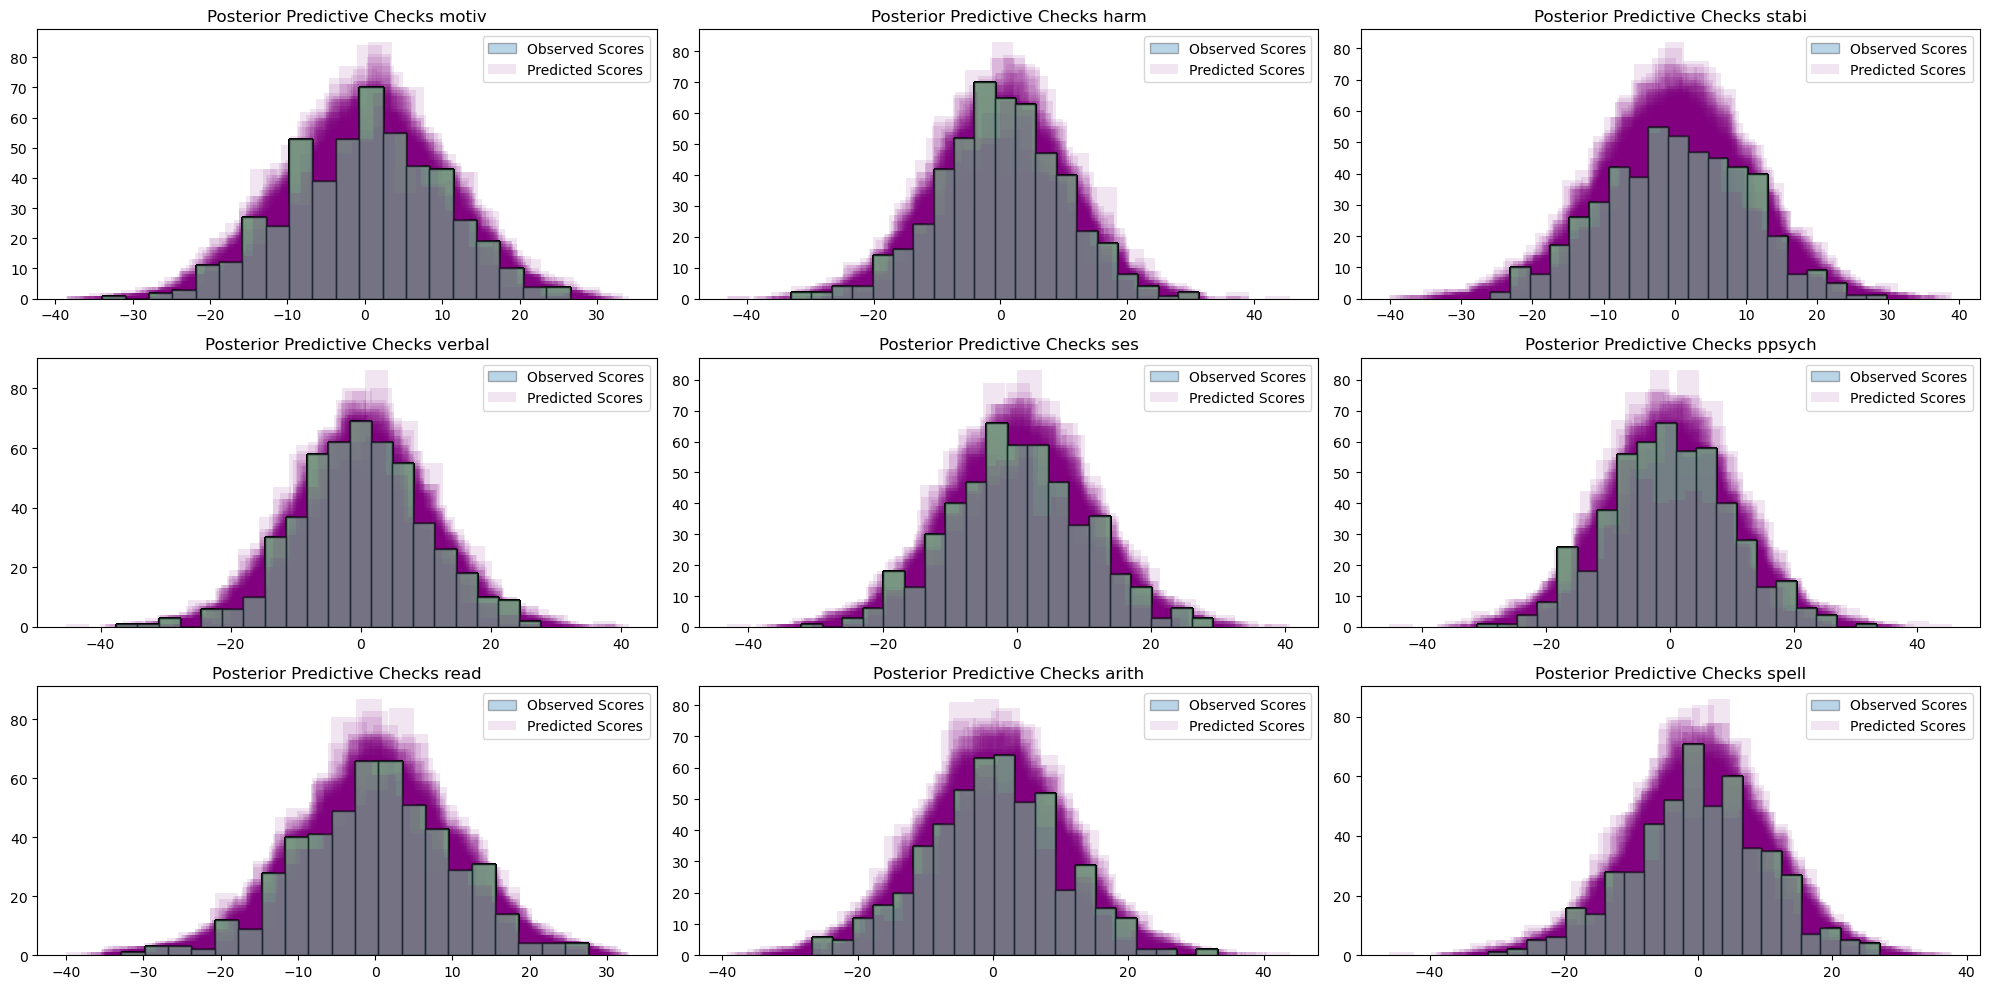

In [294]:
make_ppc(idata_sem)

In [295]:
residuals_posterior_cov = get_posterior_resids(idata_sem, 1000)
residuals_posterior_corr = get_posterior_resids(idata_sem, 1000, metric="corr")

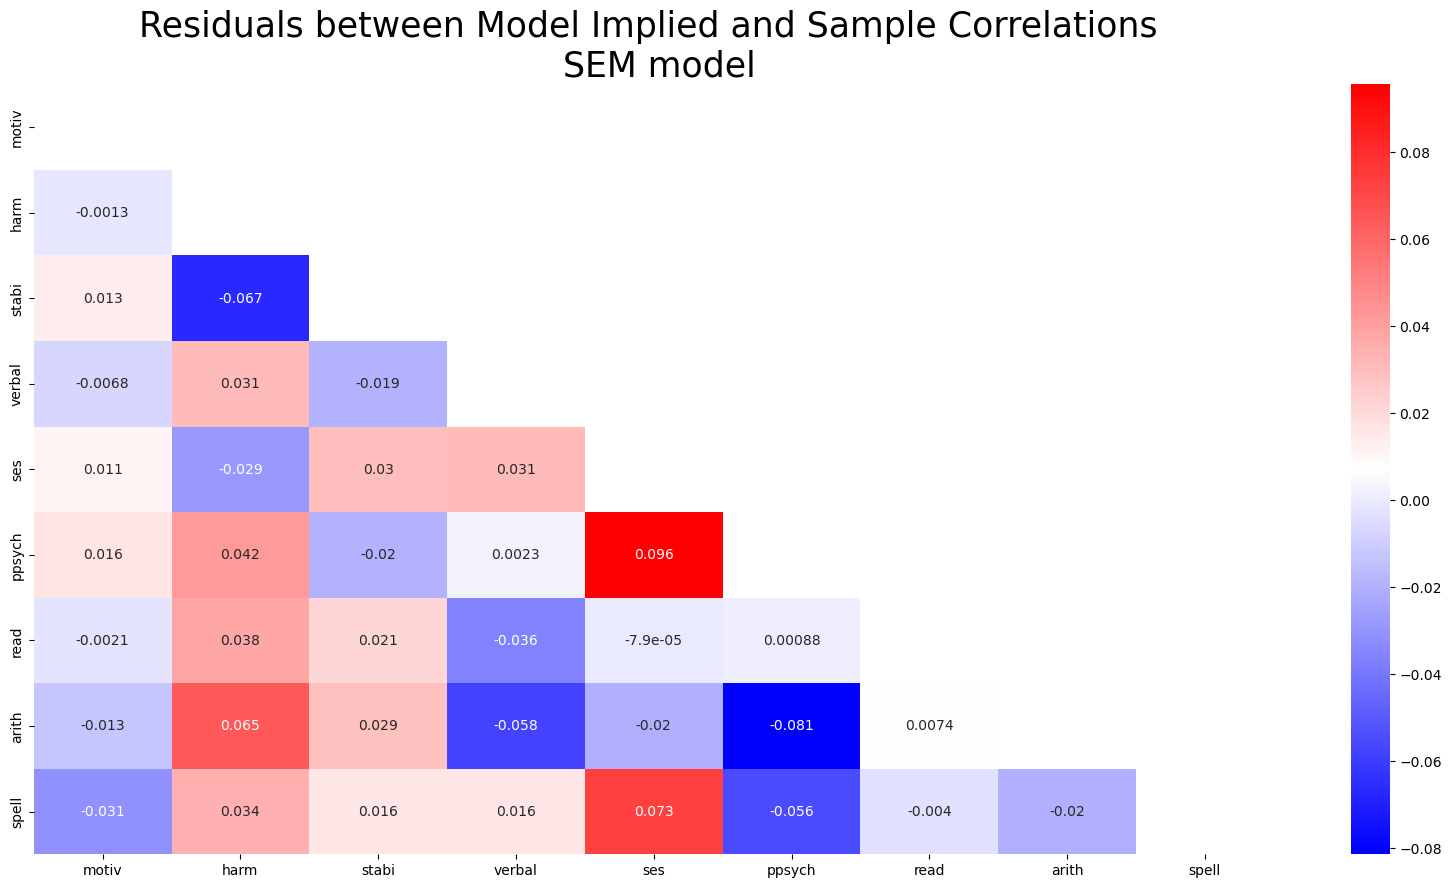

In [296]:
fig, ax = plt.subplots(figsize=(20, 10))
mask = np.triu(np.ones_like(residuals_posterior_corr, dtype=bool))
ax = sns.heatmap(residuals_posterior_corr, annot=True, cmap="bwr", mask=mask)
ax.set_title("Residuals between Model Implied and Sample Correlations \n SEM model", fontsize=25);

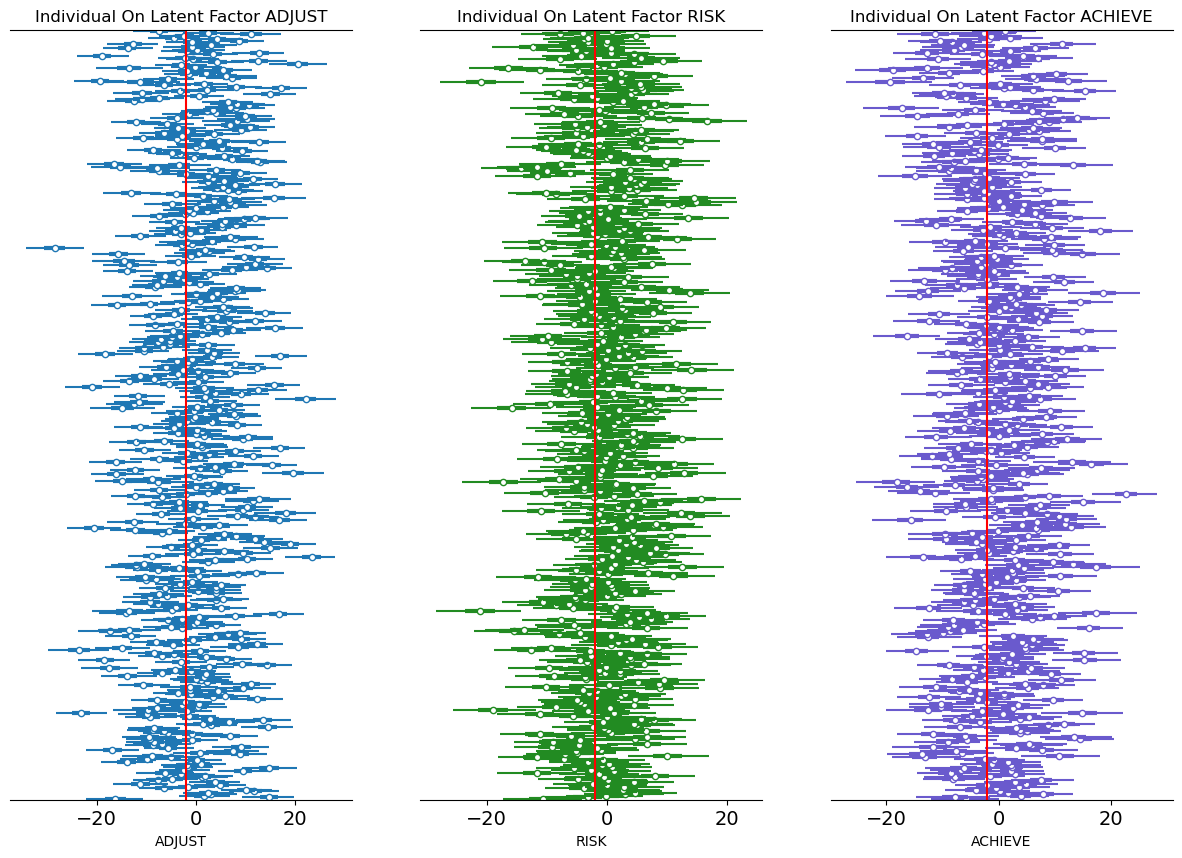

In [297]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
ax2 = axs[2]
az.plot_forest(idata_sem, var_names=["ksi"], combined=True, ax=ax, coords={"latent": ["adjust"]})
az.plot_forest(
    idata_sem,
    var_names=["ksi"],
    combined=True,
    ax=ax1,
    colors="forestgreen",
    coords={"latent": ["risk"]},
)
az.plot_forest(
    idata_sem,
    var_names=["ksi"],
    combined=True,
    ax=ax2,
    colors="slateblue",
    coords={"latent": ["achieve"]},
)
ax.set_yticklabels([])
ax.set_xlabel("ADJUST")
ax1.set_yticklabels([])
ax1.set_xlabel("RISK")
ax2.set_yticklabels([])
ax2.set_xlabel("ACHIEVE")
ax.axvline(-2, color="red")
ax1.axvline(-2, color="red")
ax2.axvline(-2, color="red")
ax.set_title("Individual On Latent Factor ADJUST")
ax1.set_title("Individual On Latent Factor RISK")
ax2.set_title("Individual On Latent Factor ACHIEVE")
plt.show();

In [302]:
compare_df = az.compare({'SEM': idata_sem, 'CFA': idata}, 'waic')
compare_df

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
SEM,0,-14525.202949,905.303983,0.000000,1.0,49.632750,0.000000,True,log
CFA,1,-14748.968775,939.024032,223.765826,0.0,48.571539,12.080799,True,log


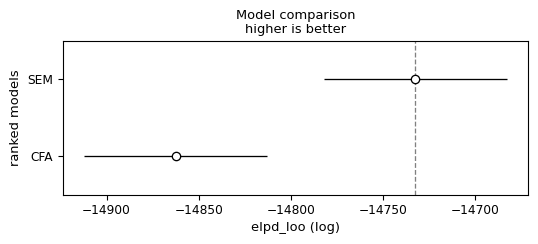

In [301]:
az.plot_compare(compare_df);

## Counterfactual Analysis

In [195]:
model_sem

                  lambdas1_ ~ Normal(1, 0.5)
                  lambdas2_ ~ Normal(1, 0.5)
                  lambdas3_ ~ Normal(1, 0.5)
                   chol_cov ~ _lkjcholeskycov(3, 2, Exponential(f()))
                        ksi ~ MultivariateNormal(f(chol_cov), f(chol_cov))
                      betas ~ Normal(0, 0.5)
                        Psi ~ InverseGamma(2, 13)
                   lambdas1 ~ Deterministic(f(lambdas1_))
                   lambdas2 ~ Deterministic(f(lambdas2_))
                   lambdas3 ~ Deterministic(f(lambdas3_))
              chol_cov_corr ~ Deterministic(f(chol_cov))
              chol_cov_stds ~ Deterministic(f(chol_cov))
endogenous_structural_paths ~ Deterministic(f(ksi, betas))
                         mu ~ Deterministic(f(ksi, betas, lambdas3_, lambdas2_, lambdas1_))
                 likelihood ~ Normal(mu, Psi)

In [252]:
model_beta0 = do(model_sem, {"betas": [0, 0 , 0]}, prune_vars=True)
model_beta1 = do(model_sem, {"betas": [.6, .3, .7]}, prune_vars=True)
model_beta0

                  lambdas1_ ~ Normal(1, 0.5)
                  lambdas2_ ~ Normal(1, 0.5)
                  lambdas3_ ~ Normal(1, 0.5)
                   chol_cov ~ _lkjcholeskycov(3, 2, Exponential(f()))
                        ksi ~ MultivariateNormal(f(chol_cov), f(chol_cov))
                        Psi ~ InverseGamma(2, 13)
endogenous_structural_paths ~ Deterministic(f(ksi))
                   lambdas3 ~ Deterministic(f(lambdas3_))
                   lambdas2 ~ Deterministic(f(lambdas2_))
                   lambdas1 ~ Deterministic(f(lambdas1_))
                         mu ~ Deterministic(f(ksi, lambdas3_, lambdas2_, lambdas1_))
                 likelihood ~ Normal(f(ksi, lambdas1_, lambdas2_, lambdas3_), Psi)

In [253]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_z0 = pm.sample_posterior_predictive(
    idata_sem,
    model=model_beta0,
    predictions=False,
    var_names=["likelihood", "betas",],
)


# Sample new sales data assuming Google Ads off: P(Y | c, do(z=1))
idata_z1 = pm.sample_posterior_predictive(
    idata_sem,
    model=model_beta1,
    predictions=False,
    var_names=["likelihood", "betas"],
)

Sampling: [likelihood]


Output()

Sampling: [likelihood]


Output()

In [254]:
pd.DataFrame((idata_z0['posterior_predictive']['likelihood'] - idata_z1['posterior_predictive']['likelihood']).mean(dim=('chain', 'draw')).values)

,0,1,2,3,4,5,6,7,8
0,-0.550044,-0.611088,-0.628768,0.086788,-0.010003,-0.108678,4.889491,4.983223,4.915345
1,2.344756,2.603190,2.575534,0.071091,0.038979,-0.105043,-0.486688,-0.592597,-0.573594
2,4.672426,4.526858,4.723740,-0.134112,-0.107309,-0.067223,-5.387882,-5.387973,-5.491420
3,-2.819183,-2.772283,-2.644945,0.060841,0.001182,-0.242429,0.159944,0.115791,0.183742
4,1.863068,1.877680,1.869703,-0.162434,0.054977,-0.172869,3.982492,4.081118,4.022108
...,...,...,...,...,...,...,...,...,...
495,-2.877307,-2.741793,-2.712314,0.295789,0.118695,-0.106244,-3.244289,-3.269911,-3.144995
496,-1.806035,-1.866611,-1.708778,-0.034715,-0.125841,0.024298,-3.121126,-3.169021,-3.109019
497,0.062248,0.152307,0.047685,-0.045339,0.058982,0.127697,-1.064855,-1.074607,-0.996607
498,1.900756,1.845868,1.797741,-0.037267,-0.175881,-0.083982,-9.418460,-9.405972,-9.496412


In [255]:
residuals_posterior_corr0 = get_posterior_resids(idata_z0, 1000, metric="corr")

residuals_posterior_corr1 = get_posterior_resids(idata_z1, 1000, metric="corr")

In [256]:
residuals_posterior_corr0 - residuals_posterior_corr1

,motiv,harm,stabi,verbal,ses,ppsych,read,arith,spell
motiv,0.000000,-0.082205,-0.130390,-0.242107,-0.193577,0.184254,-0.897010,-0.817537,-0.876321
harm,-0.082205,0.000000,-0.154298,-0.251194,-0.202228,0.193474,-0.795131,-0.721661,-0.772816
stabi,-0.130390,-0.154298,0.000000,-0.259143,-0.209786,0.191927,-0.667100,-0.600199,-0.653357
verbal,-0.242107,-0.251194,-0.259143,0.000000,0.006914,0.000030,-0.232936,-0.244641,-0.239960
ses,-0.193577,-0.202228,-0.209786,0.006914,0.000000,0.006726,-0.190744,-0.210943,-0.196132
ppsych,0.184254,0.193474,0.191927,0.000030,0.006726,0.000000,0.179593,0.192383,0.185316
read,-0.897010,-0.795131,-0.667100,-0.232936,-0.190744,0.179593,0.000000,-0.182936,-0.086550
arith,-0.817537,-0.721661,-0.600199,-0.244641,-0.210943,0.192383,-0.182936,0.000000,-0.228749
spell,-0.876321,-0.772816,-0.653357,-0.239960,-0.196132,0.185316,-0.086550,-0.228749,0.000000


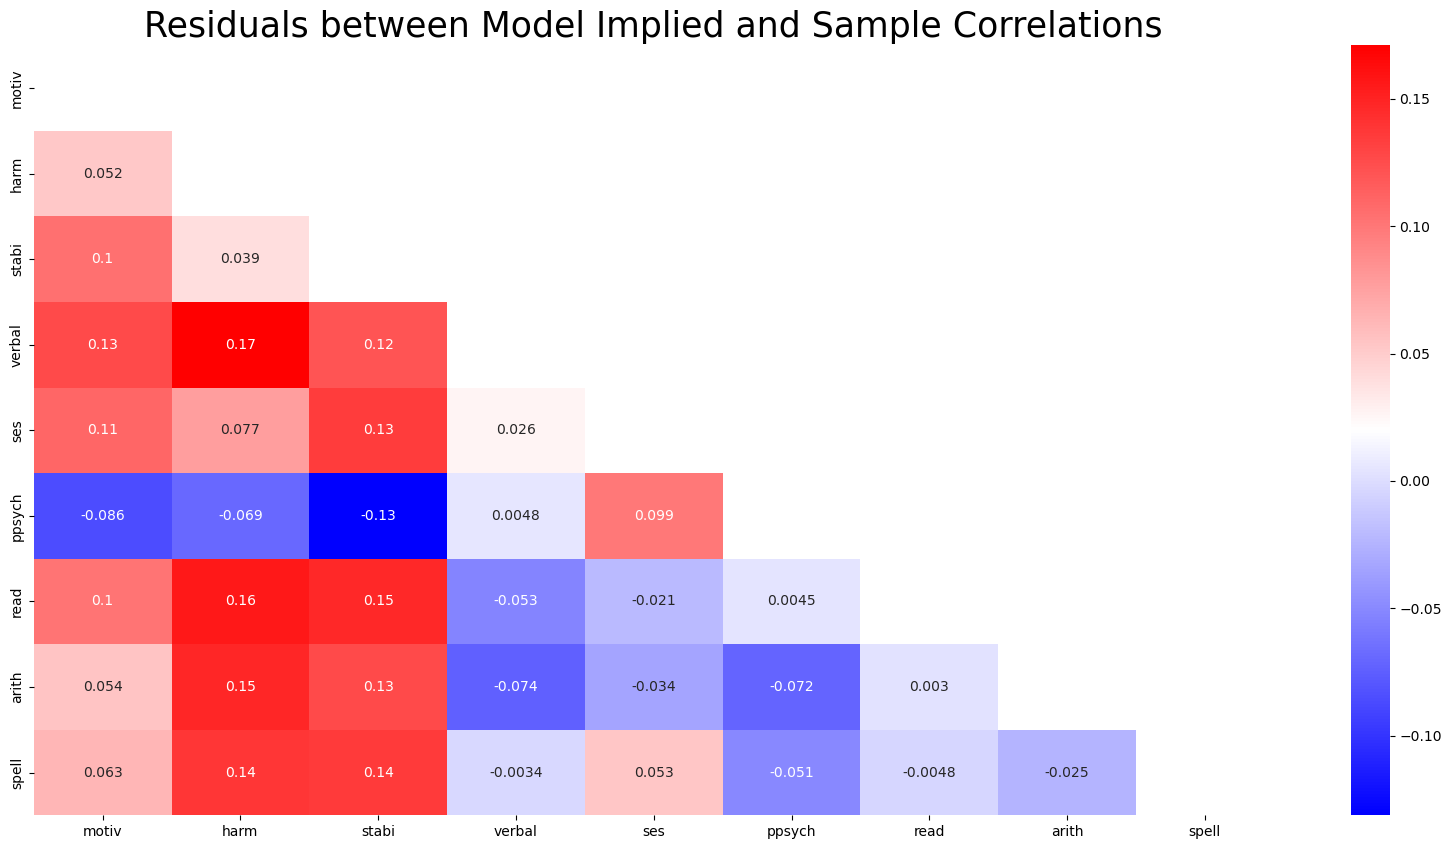

In [257]:
fig, ax = plt.subplots(figsize=(20, 10))
mask = np.triu(np.ones_like(residuals_posterior_corr1, dtype=bool))
ax = sns.heatmap(residuals_posterior_corr1, annot=True, cmap="bwr", mask=mask)
ax.set_title("Residuals between Model Implied and Sample Correlations", fontsize=25);

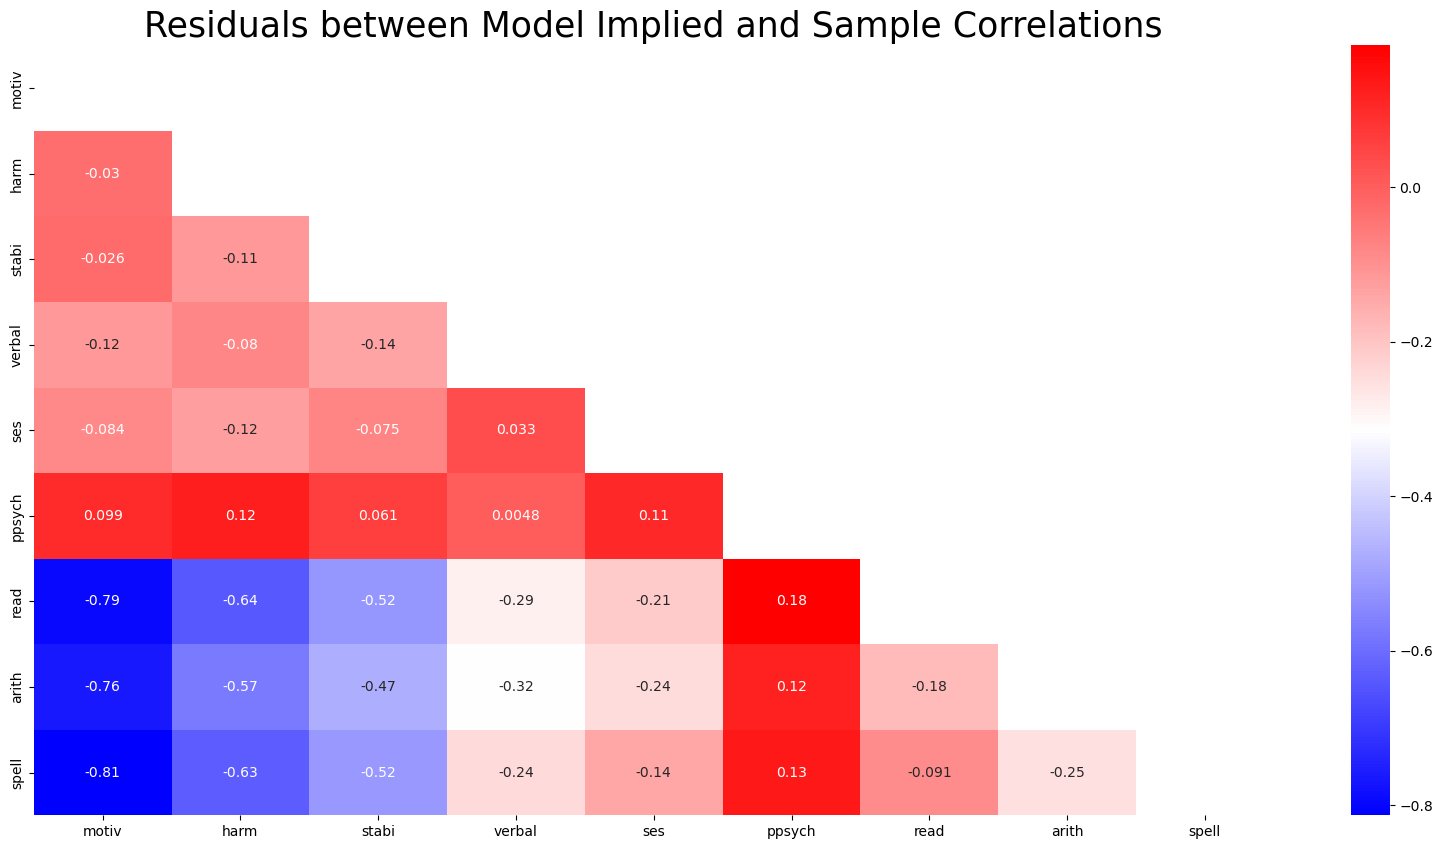

In [258]:
fig, ax = plt.subplots(figsize=(20, 10))
mask = np.triu(np.ones_like(residuals_posterior_corr0, dtype=bool))
ax = sns.heatmap(residuals_posterior_corr0, annot=True, cmap="bwr", mask=mask)
ax.set_title("Residuals between Model Implied and Sample Correlations", fontsize=25);